In [ ]:
# Import libraries
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.5.0


In [ ]:
# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    

In [ ]:
# Function to load and preprocess the image
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  This function reads an image from the filename and turns it into a tensor and
  reshapes it to (224, 224, 3)

  Parameters:
  filename: string filename of target image
  img_shape: size to resize target image to (default is 224)
  scale: to scale pixel values to range(0, 1) (default is True)
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    return img/255. # rescales values between 0 and 1
  else:
    return img  

In [ ]:
# Function to plot and predicit on images
def pred_and_plot(model, filename, target_labels):
  """
  Imports an image located at filename, makes a predicition on it with a 
  trained model  and plots the image with the predicted class as the title
  """
  # Import the target image and preprocess it 
  img = load_and_prep(filename, scale=False)

  # Make a predicition
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = target_labels[pred.argmax()]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis("off");

In [ ]:
train_dir = "/content/drive/MyDrive/Project_SignLanguageforNumbers/train"
test_dir = "/content/drive/MyDrive/Project_SignLanguageforNumbers/test"

# How many images/classes are there?
walk_through_dir("/content/drive/MyDrive/Project_SignLanguageforNumbers")

There are 2 directories and 0 images in '/content/drive/MyDrive/Project_SignLanguageforNumbers'.
There are 10 directories and 0 images in '/content/drive/MyDrive/Project_SignLanguageforNumbers/train'.
There are 0 directories and 1125 images in '/content/drive/MyDrive/Project_SignLanguageforNumbers/train/0'.
There are 0 directories and 1125 images in '/content/drive/MyDrive/Project_SignLanguageforNumbers/train/1'.
There are 0 directories and 1125 images in '/content/drive/MyDrive/Project_SignLanguageforNumbers/train/2'.
There are 0 directories and 1125 images in '/content/drive/MyDrive/Project_SignLanguageforNumbers/train/3'.
There are 0 directories and 1125 images in '/content/drive/MyDrive/Project_SignLanguageforNumbers/train/4'.
There are 0 directories and 1125 images in '/content/drive/MyDrive/Project_SignLanguageforNumbers/train/5'.
There are 0 directories and 1125 images in '/content/drive/MyDrive/Project_SignLanguageforNumbers/train/6'.
There are 0 directories and 1125 images in 

In [ ]:
# Setting up data images
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 image_size=(224, 224),
                                                                 batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=(224, 224),
                                                                batch_size=32,
                                                                shuffle=False)

Found 11250 files belonging to 10 classes.
Found 3750 files belonging to 10 classes.


In [ ]:
test_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [ ]:
# Building a Functional EfficientNetB4 model

# Setting up the base model and freezing it's layers
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False

# Setting up model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs, training=False)  # base model is in inference mode 
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model = keras.Model(inputs, outputs) 


71688192/71686520 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, None, None, 1792)  17673823  
_________________________________________________________________
global_average_pooling (Glob (None, 1792)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                17930     
Total params: 17,691,753
Trainable params: 17,930
Non-trainable params: 17,673,823
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# Fit the model
history = model.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(len(test_data)*0.25),  # validating on 15% of testing data
                    verbose=1)

Epoch 1/5
352/352 [==============================] - 1888s 5s/step - loss: 1.0520 - accuracy: 0.7019 - val_loss: 1.3342 - val_accuracy: 0.5905
Epoch 2/5
352/352 [==============================] - 72s 203ms/step - loss: 0.5662 - accuracy: 0.8570 - val_loss: 1.1948 - val_accuracy: 0.6422
Epoch 3/5
352/352 [==============================] - 72s 204ms/step - loss: 0.4341 - accuracy: 0.8928 - val_loss: 1.1227 - val_accuracy: 0.6606
Epoch 4/5
352/352 [==============================] - 73s 206ms/step - loss: 0.3596 - accuracy: 0.9135 - val_loss: 1.0854 - val_accuracy: 0.6638
Epoch 5/5
352/352 [==============================] - 73s 207ms/step - loss: 0.3099 - accuracy: 0.9257 - val_loss: 1.0381 - val_accuracy: 0.6735


In [ ]:
# Evaluate the model
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

118/118 [==============================] - 25s 189ms/step - loss: 0.7002 - accuracy: 0.7776


[0.7002174854278564, 0.7775999903678894]

In [ ]:
# Fine tuning
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [ ]:
# Recompile our model with lower learning rate 
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
# Fit the model
fine_tune_epochs = 10 

history_fine_tune = model.fit(train_data,
                              epochs=fine_tune_epochs,
                              validation_data=test_data,
                              validation_steps=int(len(test_data)*0.15),
                              initial_epoch=history.epoch[-1])

Epoch 5/10
352/352 [==============================] - 142s 209ms/step - loss: 0.2140 - accuracy: 0.9389 - val_loss: 1.0592 - val_accuracy: 0.7243
Epoch 6/10
352/352 [==============================] - 72s 204ms/step - loss: 0.1138 - accuracy: 0.9692 - val_loss: 1.1792 - val_accuracy: 0.7206
Epoch 7/10
352/352 [==============================] - 73s 207ms/step - loss: 0.0690 - accuracy: 0.9828 - val_loss: 1.2243 - val_accuracy: 0.7022
Epoch 8/10
352/352 [==============================] - 73s 206ms/step - loss: 0.0429 - accuracy: 0.9901 - val_loss: 1.2409 - val_accuracy: 0.7261
Epoch 9/10
352/352 [==============================] - 73s 206ms/step - loss: 0.0291 - accuracy: 0.9940 - val_loss: 1.2334 - val_accuracy: 0.7316
Epoch 10/10
352/352 [==============================] - 73s 207ms/step - loss: 0.0210 - accuracy: 0.9962 - val_loss: 1.2354 - val_accuracy: 0.7408


In [ ]:
# Evaluate the model
fine_tune_results = model.evaluate(test_data)
fine_tune_results

118/118 [==============================] - 22s 190ms/step - loss: 0.4822 - accuracy: 0.8816


[0.4822496175765991, 0.881600022315979]

# Accuracy and Loss Curves

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
# Let's create a function to compare training histories
def compare_history(org_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow history objects
  """
  loss = org_history.history["loss"]
  acc = org_history.history["accuracy"]
  
  val_loss = org_history.history["val_loss"]
  val_acc = org_history.history["val_accuracy"]

  # Combine original history
  total_loss = loss + new_history.history["loss"]
  total_acc = acc + new_history.history["accuracy"]

  total_val_loss = val_loss + new_history.history["val_loss"]
  total_val_acc = val_acc + new_history.history["val_accuracy"]


  # Make plots for accuracy
  plt.figure(figsize=(9, 9))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Validation Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start fine tuning")
  plt.legend(loc="lower right")
  plt.title("Training and validation Accuracy")

  
  # Make plots for loss
  plt.figure(figsize=(9, 9))
  plt.subplot(2, 1, 1)
  plt.plot(total_loss, label="Training loss")
  plt.plot(total_val_loss, label="Validation loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start fine tuning")
  plt.legend(loc="upper right")
  plt.title("Training and validation loss")

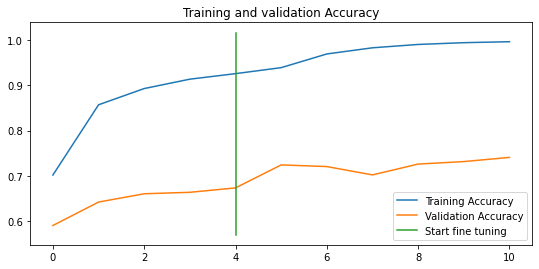

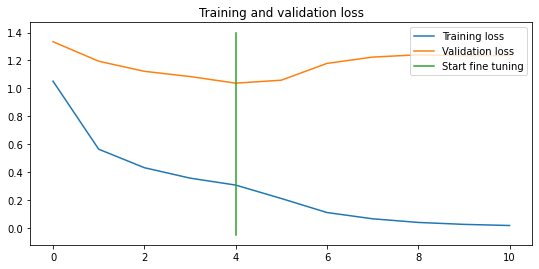

In [ ]:
# Check out our model's training curves
compare_history(history, history_fine_tune, initial_epochs=5)

# Making predictions

In [ ]:
pred_probs = model.predict(test_data, verbose=1)
pred_class = pred_probs.argmax(axis=1)

118/118 [==============================] - 18s 134ms/step


In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_labels, pred_class)
accuracy

0.8816

In [ ]:
class_names = test_data.class_names

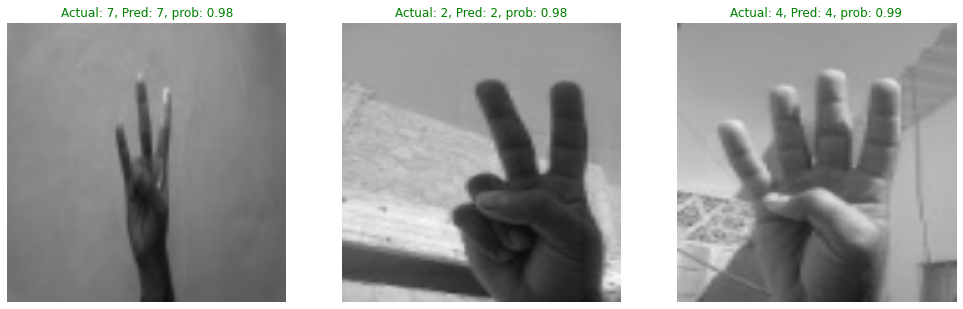

In [ ]:
# Visualising the predicitons
import random
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(17, 10))
for i in range(3):

  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)  # Since the images are grayscale
  hand_sign = np.repeat(img, 3, -1)
  #print(hand_sign) 

  pred_prob = model.predict(tf.expand_dims(hand_sign, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  plt.subplot(1, 3, i+1)
  plt.imshow(hand_sign/255.)

  if class_name == pred_class:
    color = "g"
  else:
    color = "r"

  plt.title(f"Actual: {class_name}, Pred: {pred_class}, prob: {pred_prob.max():.2f}", c=color)
  plt.axis(False)  

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


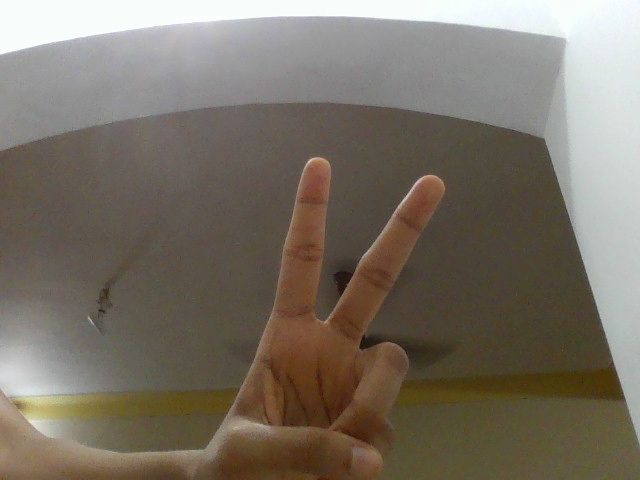

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

(-0.5, 223.5, 223.5, -0.5)

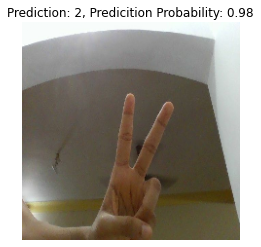

In [ ]:
# Prediciting on own custom images  
img = load_and_prep_image("/content/photo.jpg", scale=False)
pred_probs = model.predict(tf.expand_dims(img, axis=0))
pred_class = class_names[pred_probs.argmax()]

plt.imshow(img/255.)
plt.title(f"Prediction: {pred_class}, Predicition Probability: {pred_probs.max():.2f}")
plt.axis(False)